<a href="https://colab.research.google.com/github/ipeirotis/dealing_with_data/blob/master/06-Spatial_Data_and_Maps/A-Intro_to_Spatial_Data_US_census_tracts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to Spatial Data: US census tracts and zipcodes

In [1]:
# @title Setup

!pip install -U -q geopandas tdqm folium mapclassify

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

# Change the graph defaults
plt.rcParams['figure.figsize'] = (8, 3)  # Default figure size of 6x2 inches
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = 'lightgray'
plt.rcParams['font.size'] = 10  # Default font size of 12 points
plt.rcParams['lines.linewidth'] = 1  # Default line width of 1 points
plt.rcParams['lines.markersize'] = 3  # Default marker size of 3 points
plt.rcParams['legend.fontsize'] = 10  # Default legend font size of 10 poin

## Types of Geographical Data and _Shapefiles_

When we deal with spatial data, we mainly deal with three general types of data:

* Points (e.g., lon/lat coordinates for a location)
* Lines (e.g., subway line)
* Polygons (e.g., borders of a country, state, zipcode etc)

From an analytics point of view, we are espeially interested in segmenting our data based on geography, and if possible also add additional information about the geographical area (e.g., population, average income etc).

There is a wide variety of geographical data available online. A big supplier of high-quality geographical data for the US is the US Census. They provide a complex geographical hierarchy, but at the basic level it is:

```
states > counties > tracts > blockgroups > blocks
```

The US Census tracts are roughly the size of zipcodes (in fact, a bit smaller, there are around 70K tracts and around 35K zipcodes in the US), and are a very common unit of statistical analysis. In fact, due to the carefulness in which US Census creates the tracts, to be as homogeneous as possible, it is a better geographical division that zipcodes.

## Examples of Geospatial Data offered by US Census

At data.gov you can find a [wide variety of geospatial data](https://catalog.data.gov/dataset/?metadata_type=geospatial). You may want to browse through some of the datasets.



## FIPS, States, and Counties

A good source of shapefiles for the US is the `TIGER` shapefiles offered by the US Census. For example, we can [get the shapes of all the US Counties](https://catalog.data.gov/dataset/tiger-line-shapefile-2019-nation-u-s-current-county-and-equivalent-national-shapefile).



In [10]:
counties_url = 'https://www2.census.gov/geo/tiger/TIGER2019/COUNTY/tl_2019_us_county.zip'
counties_df = gpd.GeoDataFrame.from_file(counties_url)

In [11]:
counties_df = counties_df.filter ( ['GEOID', 'STATEFP', 'COUNTYFP', 'NAMELSAD', 'geometry'])

In [12]:
# GEOID is the primary key for the county.
# It is a combination of the STATEFP + COUNTYFP
# The STATEFP and COUNTYFP are standardized at the federal level
# and can be used widely to refer to states and counties (and more
# fine grained entries)
counties_df

GEOID STATEFP COUNTYFP          NAMELSAD  \
0     31039      31      039     Cuming County   
1     53069      53      069  Wahkiakum County   
2     35011      35      011    De Baca County   
3     31109      31      109  Lancaster County   
4     31129      31      129   Nuckolls County   
...     ...     ...      ...               ...   
3228  13123      13      123     Gilmer County   
3229  27135      27      135     Roseau County   
3230  28089      28      089    Madison County   
3231  48227      48      227     Howard County   
3232  54099      54      099      Wayne County   

                                               geometry  
0     POLYGON ((-97.01952 42.00410, -97.01952 42.004...  
1     POLYGON ((-123.43639 46.23820, -123.44759 46.2...  
2     POLYGON ((-104.56739 33.99757, -104.56772 33.9...  
3     POLYGON ((-96.91075 40.78494, -96.91075 40.790...  
4     POLYGON ((-98.27367 40.08940, -98.27367 40.089...  
...                                                 ...  
3228  POLYGON ((-84.65478 34.66559, -84.65488 34.669...  
3229  POLYGON ((-96.40466 48.80528, -96.40467 48.813...  
3230  POLYGON ((-90.09363 32.70763, -90.09360 32.707...  
3231  POLYGON ((-101.69227 32.27106, -101.69221 32.2...  
3232  POLYGON ((-82.59529 38.36978, -82.59515 38.369...  

[3233 rows x 5 columns]

In [13]:
# Dropping non-continental states
counties_df = counties_df.query( "STATEFP!='02'" )  # Alaska
counties_df = counties_df.query( "STATEFP!='15'" ) # Hawaii
counties_df = counties_df.query( "STATEFP!='72'" ) # Puerto Rico
counties_df = counties_df.query( "STATEFP!='66'" ) # Guam
counties_df = counties_df.query( "STATEFP!='69'" ) # Commonwealth of the Northern Mariana Islands
counties_df = counties_df.query( "STATEFP!='60'" ) # American Samoa
counties_df = counties_df.query( "STATEFP!='78'" ) # United States Virgin Islands

<Axes: >

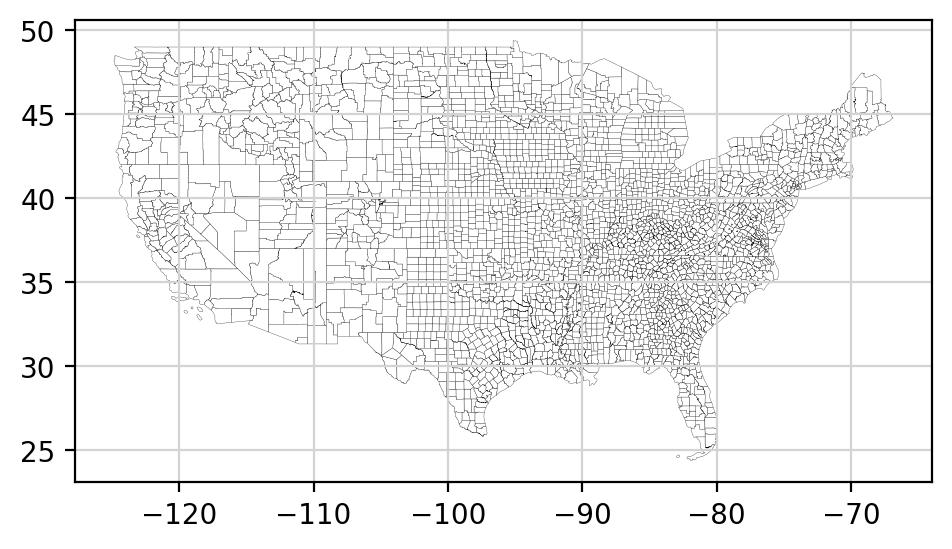

In [15]:
counties_df.plot(
    color = 'white',
    edgecolor = 'black',
    linewidth=0.1,
    zorder=0,
    facecolor = 'white',
)

### Example: Plotting Walkability Scores

Let's now use an example dataset from the EPA, the "walkability index". The Walkability Index dataset characterizes every Census 2019 **block group** in the US based on its relative walkability.

The example below will illustrate a general pattern for creating _choropleths_, a specific type of map visualization, where we color each area of interest with a color, to visualize a quantity of interest; in this case, we will visualize the walkability scores.

In [24]:
# First, we fetch the walkability dataset from EPA
walk = pd.read_csv('https://edg.epa.gov/EPADataCommons/public/OA/EPA_SmartLocationDatabase_V3_Jan_2021_Final.csv')

# A bit of bookkeeping: Making sure that the STATEFP/COUNTYFP retain their leading zeros
# and are not converted to integers.
walk.STATEFP = walk.STATEFP.astype(str).str.zfill(2)
walk.COUNTYFP = walk.COUNTYFP.astype(str).str.zfill(3)
walk.TRACTCE = walk.TRACTCE.astype(str).str.zfill(6)
walk.BLKGRPCE = walk.BLKGRPCE.astype(str)

# We make it easier to select counties based on a single column FIPS code instead of
# having separately STATEFP and COUNTYFP
walk['COUNTY_GEOID'] = walk.STATEFP.astype(str)  + walk.COUNTYFP.astype(str)

# Keep only a few of the columns in the dataset, we do not need the rest for this exercise
walk = walk.filter ( ['COUNTY_GEOID', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'NatWalkInd'])

<Axes: >

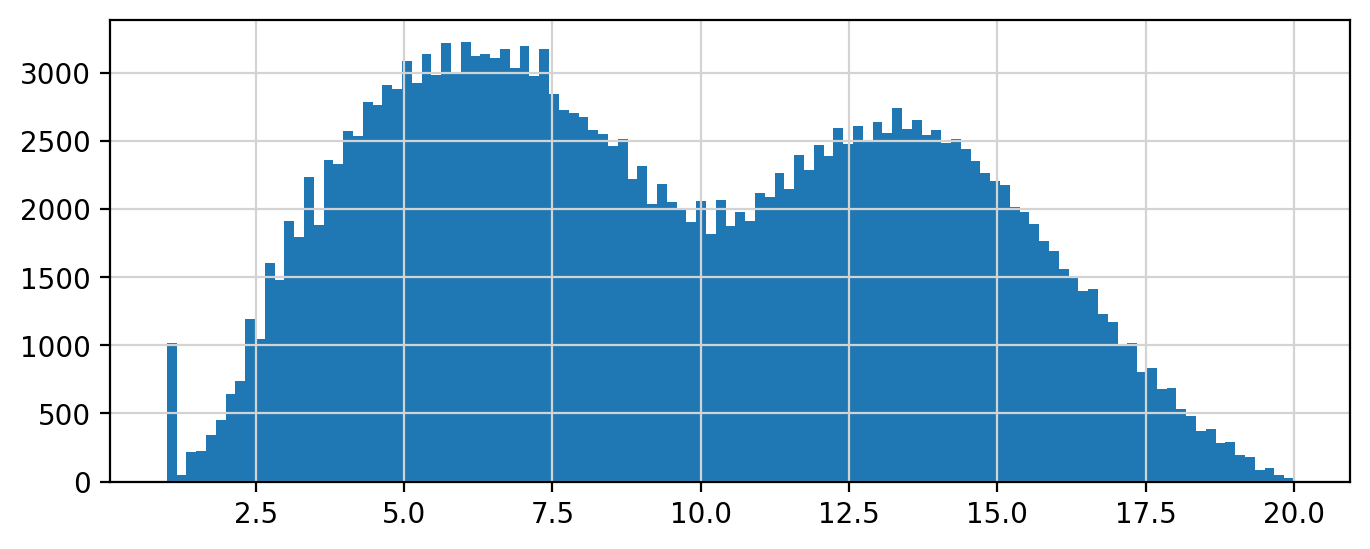

In [41]:
# Let's visualize the walkability score distribution across all 220K blockgroups
walk.NatWalkInd.hist(bins=115)

### Aggregate walkability scores on the county level

We have the data on a blockgroup level, but we want to calculate the score for counties. So we aggregate the scores across all blockgroups in a county.

In [43]:
# Now, let's calculate the average walkability score for each county.
# We will average across all blockgroups in that county.

county_walk_scores_mean = walk.pivot_table(
    index = 'COUNTY_GEOID',
    values = 'NatWalkInd',
    aggfunc = 'mean' #
)

county_walk_scores_mean

NatWalkInd
COUNTY_GEOID            
01001           5.234375
01003           6.450355
01005           5.188406
01007           5.033333
01009           4.666667
...                  ...
72151           3.402778
72153           4.559524
78010           4.201550
78020           3.500000
78030           4.631579

[3233 rows x 1 columns]

In [86]:
# @title (Optional) Alternative aggregation functions: Max & Mean of top-10%


county_walk_scores_max = walk.pivot_table(
    index = 'COUNTY_GEOID',
    values = 'NatWalkInd',
    aggfunc = 'max' # If we want to score each county based on its best score
)

# Calculates the mean across the top-10%
def top_10_percent_avg(series):
    threshold = np.ceil(len(series) * 0.1)  # Compute the number of entries for top 10%
    top_10_percent = series.nlargest(int(threshold))  # Get the top 10% values
    return top_10_percent.mean()  # Return their mean

county_walk_scores_mean10perc = walk.pivot_table(
    index = 'COUNTY_GEOID',
    values = 'NatWalkInd',
    aggfunc = top_10_percent_avg # Finds the top-10% of the blockgroups and calculates their average score
)

### Putting data together

In [46]:
# We now join the "geodataframe" counties_df, which contains the the shapes/geometries
# with the "walkability scores" and we keep at the end only the attributes that we need
gdf_scores = pd.merge(
    left = counties_df, # The geodataframe with the county shapes
    right = county_walk_scores_mean, # The walkability scores per county
    left_on="GEOID", # The id for the county in the geodataframe is GEOID
    right_index=True # The county code in the pivot table is in the index
).filter( ['GEOID', 'NAMELSAD',  'NatWalkInd', 'geometry']) # Keep only

gdf_scores

GEOID          NAMELSAD  NatWalkInd  \
0     31039     Cuming County    7.395833   
1     53069  Wahkiakum County    4.533333   
2     35011    De Baca County    6.916667   
3     31109  Lancaster County   13.232172   
4     31129   Nuckolls County    6.266667   
...     ...               ...         ...   
3228  13123     Gilmer County    5.000000   
3229  27135     Roseau County    5.358974   
3230  28089    Madison County    6.608333   
3231  48227     Howard County    7.470238   
3232  54099      Wayne County    5.250000   

                                               geometry  
0     POLYGON ((-97.01952 42.00410, -97.01952 42.004...  
1     POLYGON ((-123.43639 46.23820, -123.44759 46.2...  
2     POLYGON ((-104.56739 33.99757, -104.56772 33.9...  
3     POLYGON ((-96.91075 40.78494, -96.91075 40.790...  
4     POLYGON ((-98.27367 40.08940, -98.27367 40.089...  
...                                                 ...  
3228  POLYGON ((-84.65478 34.66559, -84.65488 34.669...  
3229  POLYGON ((-96.40466 48.80528, -96.40467 48.813...  
3230  POLYGON ((-90.09363 32.70763, -90.09360 32.707...  
3231  POLYGON ((-101.69227 32.27106, -101.69221 32.2...  
3232  POLYGON ((-82.59529 38.36978, -82.59515 38.369...  

[3108 rows x 4 columns]

In [47]:
# Let's see the most walkable counties (on average)
gdf_scores.sort_values('NatWalkInd', ascending=False).head(10)

GEOID              NAMELSAD  NatWalkInd  \
636   06075  San Francisco County   15.957258   
712   51610     Falls Church city   15.812500   
1115  51600          Fairfax city   15.666667   
319   41051      Multnomah County   15.415547   
61    25025        Suffolk County   14.936791   
599   42101   Philadelphia County   14.833583   
1855  51678        Lexington city   14.666667   
1182  51660     Harrisonburg city   14.648148   
269   51510       Alexandria city   14.511006   
631   11001  District of Columbia   14.471481   

                                               geometry  
636   MULTIPOLYGON (((-122.61228 37.81522, -122.5845...  
712   POLYGON ((-77.19499 38.89846, -77.19499 38.898...  
1115  POLYGON ((-77.33485 38.85374, -77.33480 38.853...  
319   POLYGON ((-122.86749 45.60623, -122.86830 45.6...  
61    POLYGON ((-71.03318 42.41421, -71.03301 42.414...  
599   POLYGON ((-75.28027 39.97496, -75.27951 39.975...  
1855  POLYGON ((-79.46158 37.78636, -79.45943 37.788...  
1182  POLYGON ((-78.91787 38.39415, -78.91769 38.394...  
269   POLYGON ((-77.14436 38.81036, -77.14397 38.810...  
631   POLYGON ((-77.11975 38.93435, -77.11886 38.935...

<Axes: >

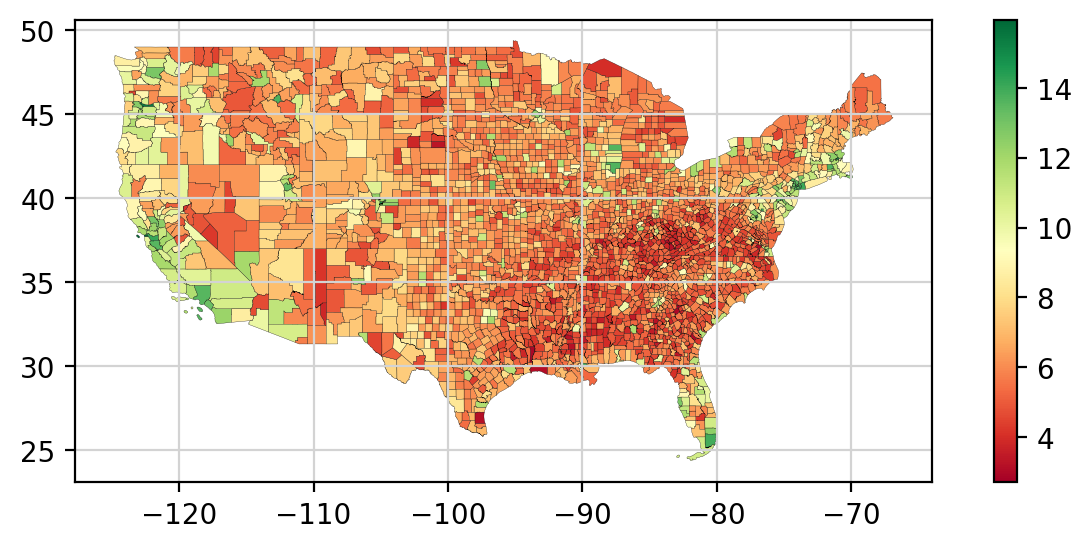

In [56]:
gdf_scores.plot(
    column = 'NatWalkInd', # Defines what column we will use for the visualization
    legend = True,
    cmap = 'RdYlGn', # This defines the color scheme that we
    edgecolor = 'black',
    linewidth=0.1,
)

<Axes: >

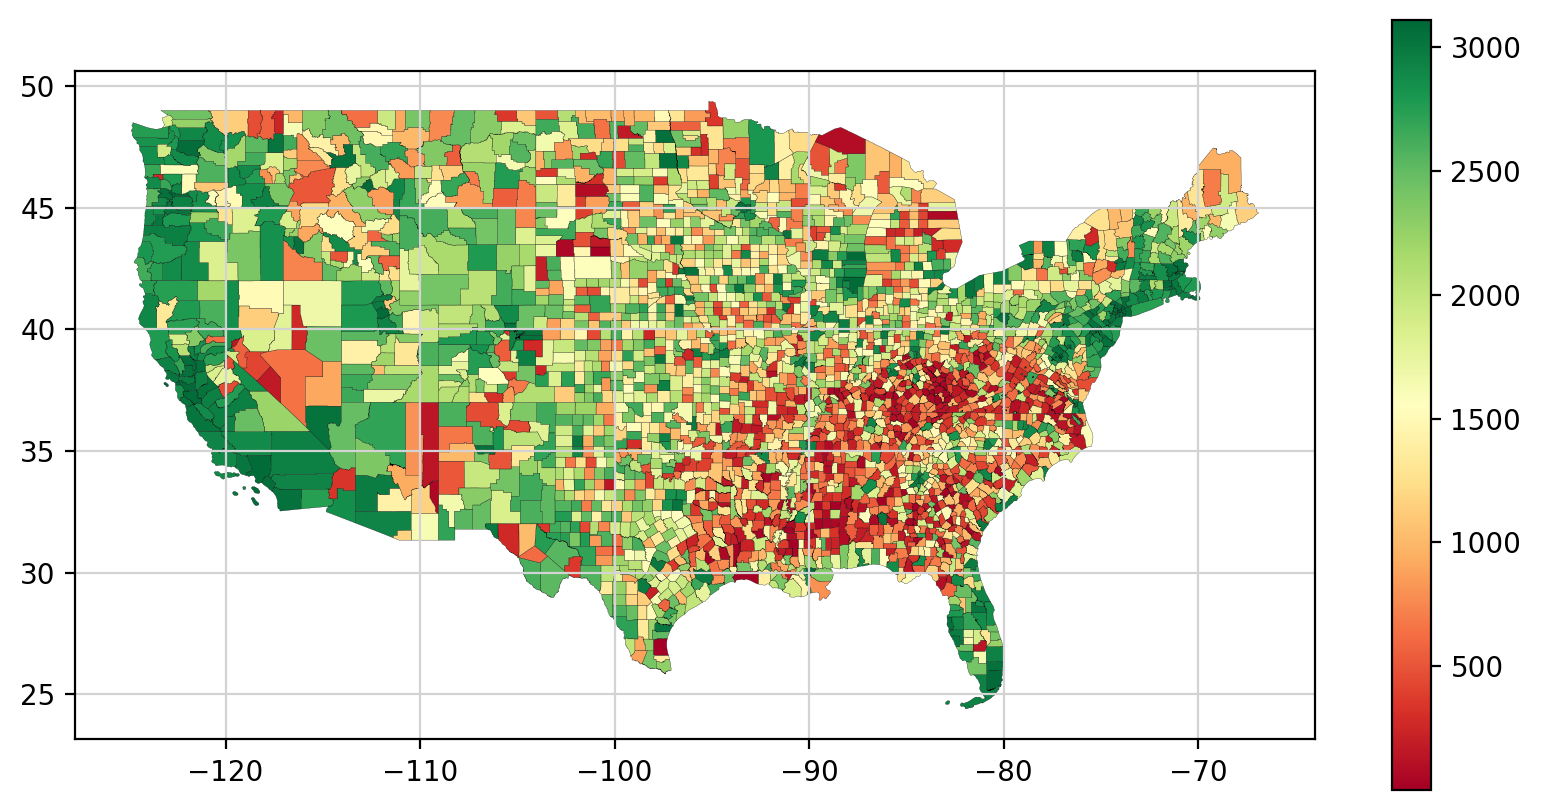

In [57]:
# When we use color scales to visualize a quantity, we often do not use the
# color space effectively, when the distribution of values is skewed.
# So, in many cases we covert the quantity into "percentiles" (or ranks)
# that are guaranteed to be uniformly distributed and allow all colors
# of the color scheme to be shown in the visualization.
gdf_scores["NatWalkInd_percentile"] = gdf_scores['NatWalkInd'].rank(pct=True)

gdf_scores.plot(
    column = 'NatWalkInd_percentile',
    legend = True,
    cmap = 'RdYlGn',
    edgecolor = 'black',
    linewidth=0.1,
)

## US Census Tracts




The US Census runs a yearly survey (the ACS survey) that collects a wide variety of detailed information about each census tract. [For example, consider the information about our own census tract](https://censusreporter.org/profiles/14000US36061005501-census-tract-5501-new-york-ny/): data about population, income, age, educational level, house values, renters vs owners, and many many other data points.

The file below contains the description of all the US Census tracts:

In [52]:
!curl https://storage.googleapis.com/datasets_nyu/usa_tracts.zip -o usa_tracts.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  650M  100  650M    0     0  73.7M      0  0:00:08  0:00:08 --:--:-- 93.5M


In [53]:
shapefile = f'usa_tracts.zip'
tracts_df = gpd.GeoDataFrame.from_file(shapefile)

# makes it easier to select counties based on their FIPS code
tracts_df.COUNTYFP = tracts_df.STATEFP.astype(str)  + tracts_df.COUNTYFP.astype(str)

In [5]:
tracts_df

STATEFP COUNTYFP TRACTCE        GEOID    NAME             NAMELSAD  \
0          01    01089  001902  01089001902   19.02   Census Tract 19.02   
1          01    01089  010800  01089010800     108     Census Tract 108   
2          01    01089  010701  01089010701  107.01  Census Tract 107.01   
3          01    01089  011014  01089011014  110.14  Census Tract 110.14   
4          01    01089  010301  01089010301  103.01  Census Tract 103.01   
...       ...      ...     ...          ...     ...                  ...   
74128      78    78030  960900  78030960900    9609    Census Tract 9609   
74129      78    78030  961000  78030961000    9610    Census Tract 9610   
74130      78    78030  961100  78030961100    9611    Census Tract 9611   
74131      78    78030  961200  78030961200    9612    Census Tract 9612   
74132      78    78030  990000  78030990000    9900    Census Tract 9900   

       MTFCC FUNCSTAT     ALAND     AWATER     INTPTLAT      INTPTLON  \
0      G5020        S  12806338       2944  +34.6825950  -086.5407538   
1      G5020        S  62435571     424127  +34.7623828  -086.4951024   
2      G5020        S  88103149     277431  +34.8667659  -086.5784822   
3      G5020        S  10928881      11607  +34.7176388  -086.7667595   
4      G5020        S  87917963     152312  +34.9392227  -086.5836942   
...      ...      ...       ...        ...          ...           ...   
74128  G5020        S   8151330    3040065  +18.3216031  -064.8883329   
74129  G5020        S   2105264    2358459  +18.3293485  -064.9347420   
74130  G5020        S   3513674          0  +18.3382853  -064.9139739   
74131  G5020        S   1017753     802134  +18.3390800  -064.9260312   
74132  G5020        S         0  687428636  +18.3261610  -064.9736117   

                                                geometry  
0      POLYGON ((-86.55607 34.67424, -86.55598 34.674...  
1      POLYGON ((-86.55461 34.78647, -86.55461 34.786...  
2      POLYGON ((-86.64287 34.87641, -86.64282 34.876...  
3      POLYGON ((-86.78654 34.70279, -86.78653 34.703...  
4      POLYGON ((-86.64212 34.93313, -86.64210 34.934...  
...                                                  ...  
74128  MULTIPOLYGON (((-64.85371 18.23233, -64.85367 ...  
74129  POLYGON ((-64.94808 18.34514, -64.94738 18.344...  
74130  POLYGON ((-64.92651 18.33030, -64.92640 18.330...  
74131  POLYGON ((-64.93271 18.34782, -64.93236 18.347...  
74132  POLYGON ((-65.15388 18.28114, -65.15364 18.293...  

[74133 rows x 13 columns]

In [54]:
# Dropping non-continental states
tracts_df = tracts_df[ tracts_df.STATEFP!='02' ]  # Alaska
tracts_df = tracts_df[ tracts_df.STATEFP!='15' ] # Hawaii
tracts_df = tracts_df[ tracts_df.STATEFP!='72' ] # Puerto Rico
tracts_df = tracts_df[ tracts_df.STATEFP!='66' ] # Guam
tracts_df = tracts_df[ tracts_df.STATEFP!='69' ] # Commonwealth of the Northern Mariana Islands
tracts_df = tracts_df[ tracts_df.STATEFP!='60' ] # American Samoa
tracts_df = tracts_df[ tracts_df.STATEFP!='78' ] # United States Virgin Islands

<Axes: >

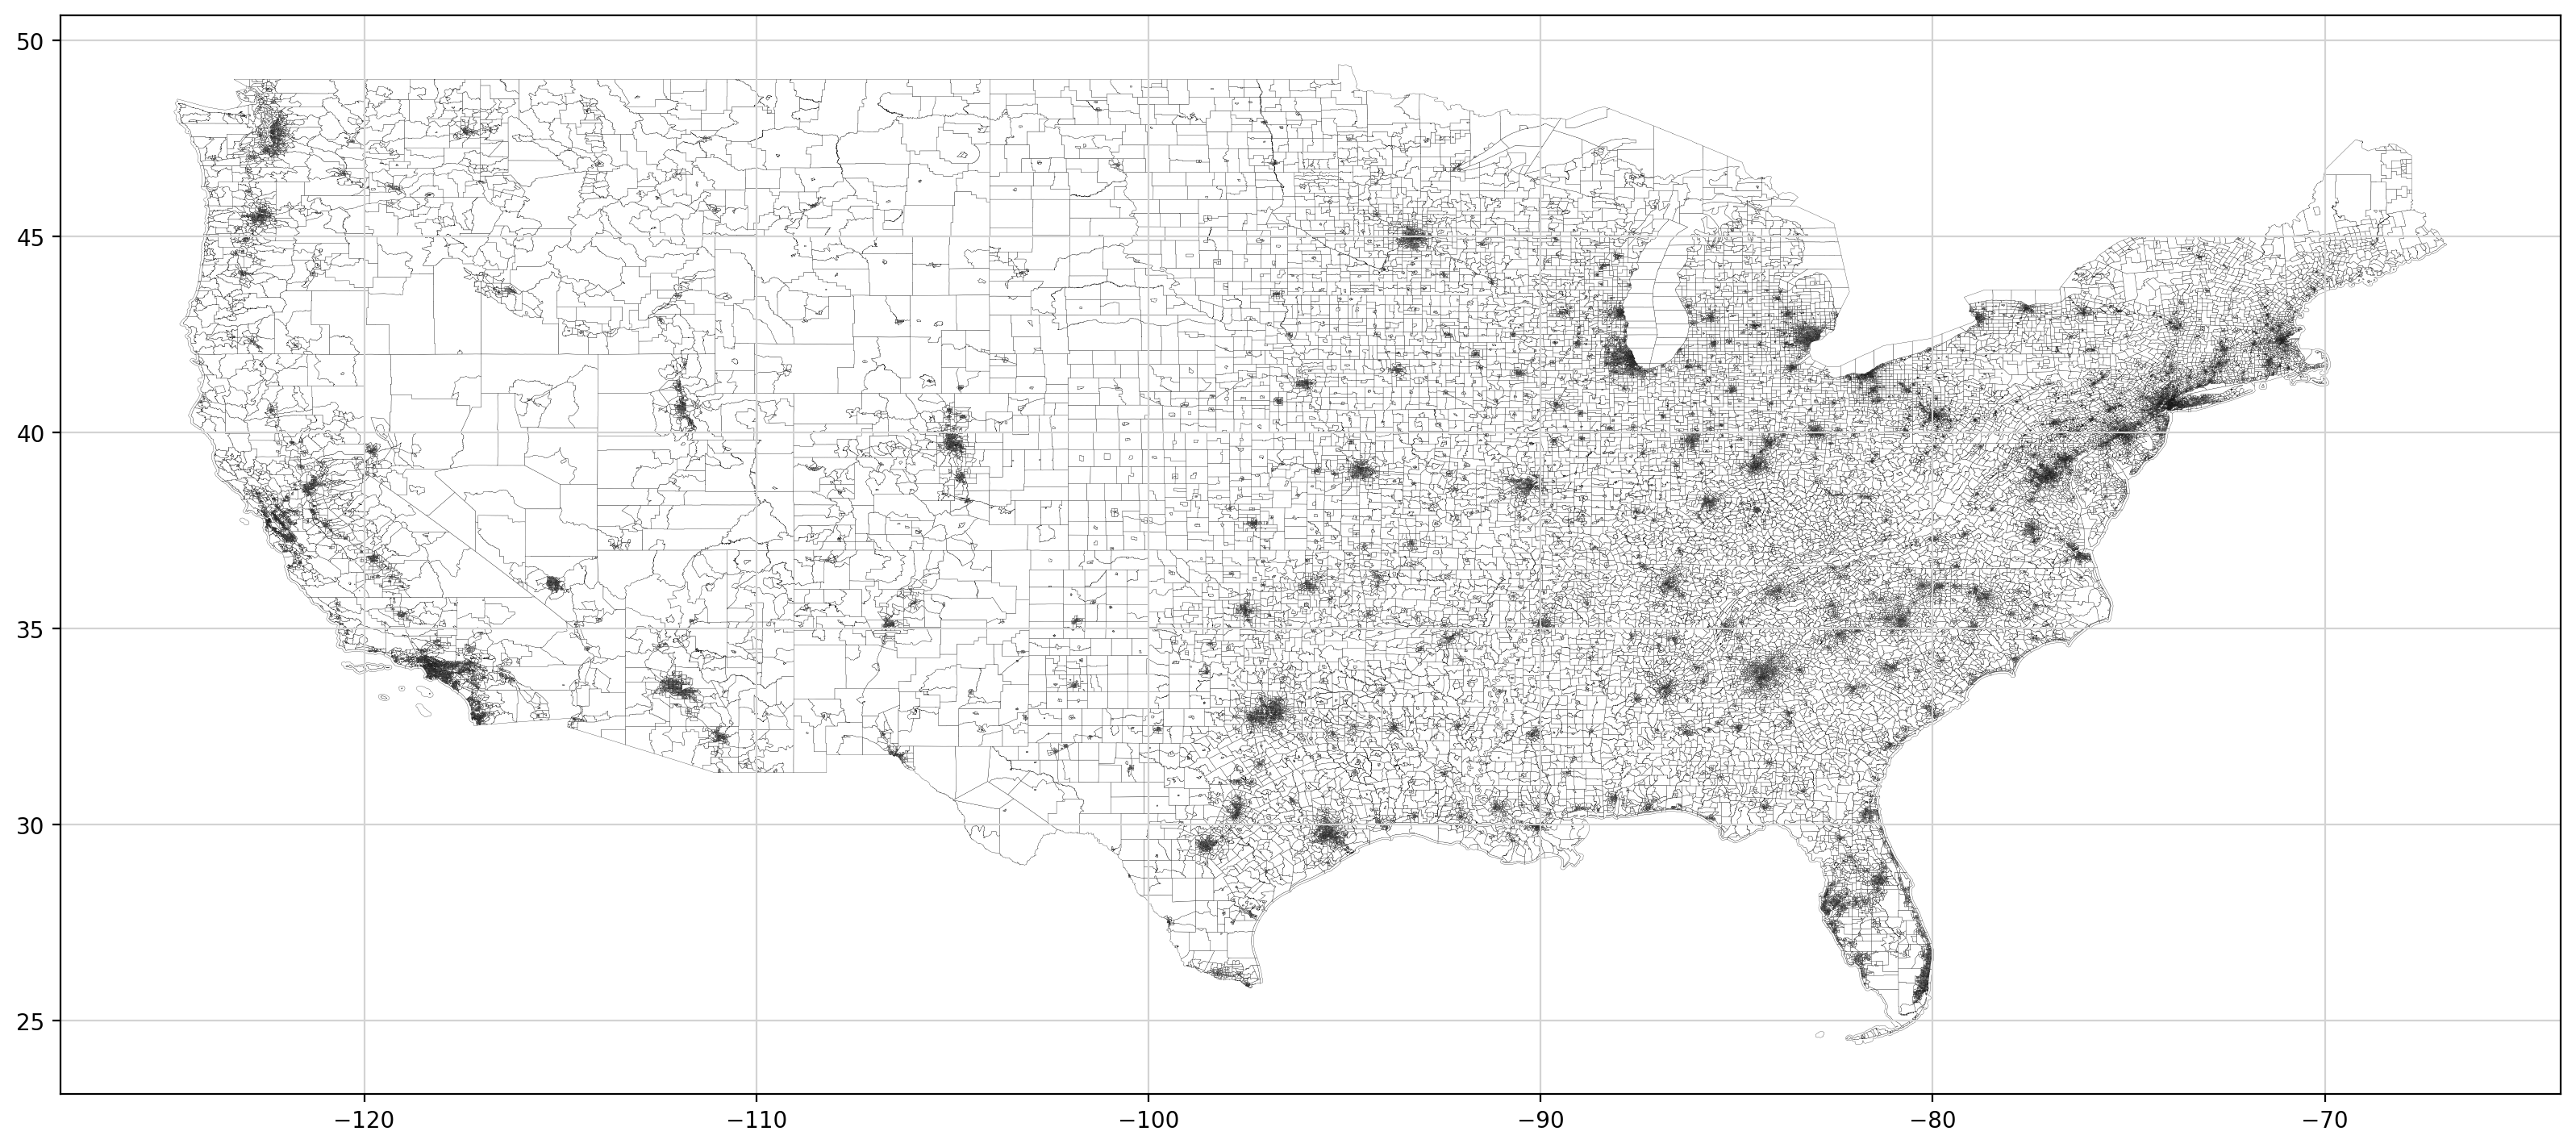

In [55]:
tracts_df.plot(
    color = 'white',
    edgecolor = 'black',
    linewidth=0.1,
    zorder=0,
    facecolor = 'white',
)

## ZIP Codes

Often people ask why we do not use zipcodes instead of census tracts.

The answer is two-fold:

* The USPS does not release shapefiles of their zipcodes
* [The zip codes are not areas](https://manifold.net/doc/mfd9/zip_codes_are_not_areas.htm). In fact they are a bunch of delivery routes/lines, not areas.
* The US Census though releases the [ZIP Code Tabulation Areas (ZCTAs)](https://www.census.gov/programs-surveys/geography/guidance/geo-areas/zctas.html)



In [8]:
!curl https://storage.googleapis.com/datasets_nyu/tl_2020_us_zcta510.zip -o tl_2020_us_zcta510.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  511M  100  511M    0     0  81.0M      0  0:00:06  0:00:06 --:--:-- 80.2M


In [9]:
shapefile = f'tl_2020_us_zcta510.zip'
zipcodes_df = gpd.GeoDataFrame.from_file(shapefile)


In [10]:
zipcodes_df

ZCTA5CE10 GEOID10 CLASSFP10 MTFCC10 FUNCSTAT10    ALAND10  AWATER10  \
0         43451   43451        B5   G6350          S   63484189    157689   
1         43452   43452        B5   G6350          S  121525288  13721740   
2         43456   43456        B5   G6350          S    9320978   1003775   
3         43457   43457        B5   G6350          S   48004678         0   
4         43458   43458        B5   G6350          S    2573816     39915   
...         ...     ...       ...     ...        ...        ...       ...   
33139     84044   84044        B5   G6350          S  123283634  69912365   
33140     84045   84045        B5   G6350          S   52799628     89968   
33141     84046   84046        B5   G6350          S  333204942   4460752   
33142     84047   84047        B5   G6350          S   16172462         0   
33143     84049   84049        B5   G6350          S  215977810  10468874   

        INTPTLAT10    INTPTLON10  \
0      +41.3183193  -083.6150363   
1      +41.5202297  -082.9770334   
2      +41.6318300  -082.8393923   
3      +41.2673301  -083.4274872   
4      +41.5304461  -083.2133648   
...            ...           ...   
33139  +40.7201095  -112.1549645   
33140  +40.3364908  -111.9111905   
33141  +40.9207693  -109.8310453   
33142  +40.6152301  -111.8907499   
33143  +40.5228727  -111.5243678   

                                                geometry  
0      POLYGON ((-83.70873 41.32733, -83.70815 41.327...  
1      POLYGON ((-83.08698 41.53780, -83.08256 41.537...  
2      MULTIPOLYGON (((-82.83558 41.71082, -82.83515 ...  
3      POLYGON ((-83.49650 41.25371, -83.48382 41.253...  
4      POLYGON ((-83.22229 41.53102, -83.22228 41.532...  
...                                                  ...  
33139  POLYGON ((-112.26022 40.76909, -112.25333 40.7...  
33140  MULTIPOLYGON (((-111.92421 40.17034, -111.9240...  
33141  POLYGON ((-110.00072 40.99745, -110.00036 40.9...  
33142  POLYGON ((-111.92141 40.62772, -111.92134 40.6...  
33143  POLYGON ((-111.59394 40.57707, -111.59386 40.5...  

[33144 rows x 10 columns]

<Axes: >

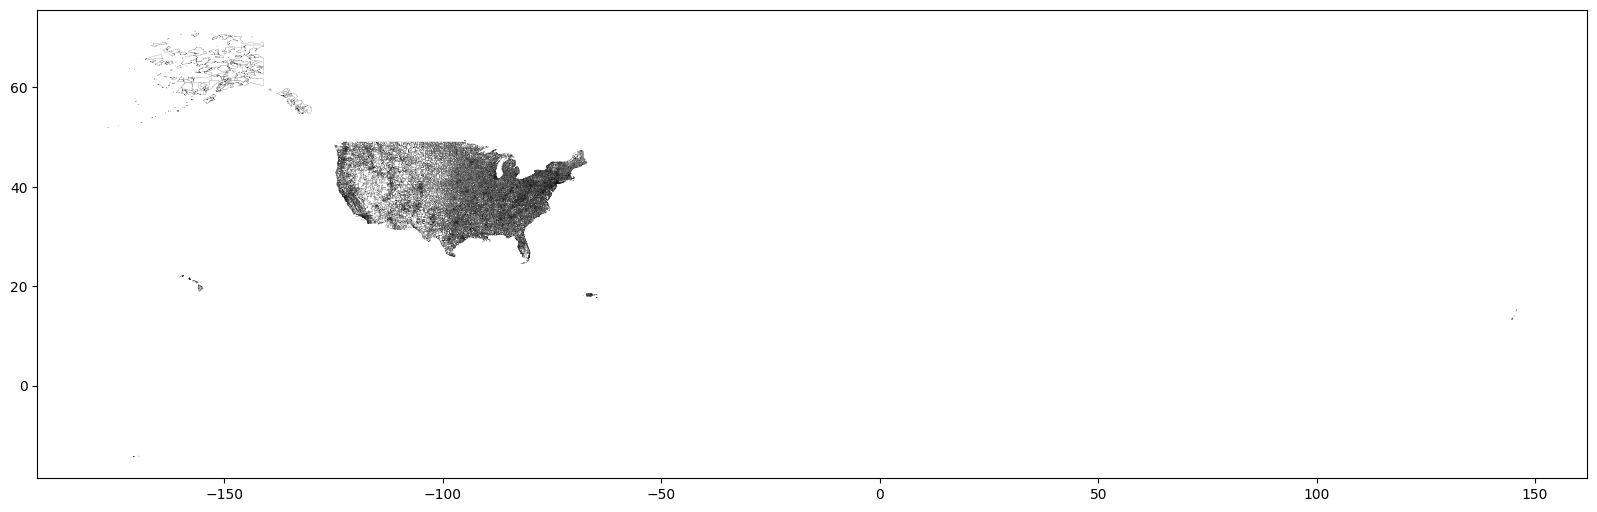

In [11]:
zipcodes_df.plot(
    figsize=(20,20),
    color = 'white',
    edgecolor = 'black',
    linewidth=0.1,
    zorder=0,
    facecolor = 'white',
)